Code to build and save various hidden weight initializations.

In [1]:
import sys

sys.path.append("..")
import BuildHiddenWeights as bhw  # builders
import HiddenWeightHelpers as hw  # plots, stats, norms, saving, open-loop
from RNN_Class import *
import math, torch, torch.nn as nn

/home/mwagner/bin/anaconda3/envs/hcprediction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Baseline

In [2]:
# prepare input -- asymmetric Gaussian
loaded = torch.load("../data/Ns100_SeqN100/encodings/Ns100_SeqN100_asym1.pth.tar")
pred = 1
X = loaded["X_mini"]
Y = loaded["Target_mini"]
X = X[:, :-pred]
Y = Y[:, pred:]

In [3]:
# build model (sigmoid head, W_xh identity) -- used for baseline
hidden_n = X.shape[-1]
model = ElmanRNN_pytorch_module_v2(hidden_n, hidden_n, hidden_n)
model.act = nn.Sigmoid()
# ser W_xh to identity matrix
for name, p in model.named_parameters():
    if name == "rnn.weight_ih_l0":
        p.data.fill_(0)
        p.data.fill_diagonal_(1)
h0 = torch.zeros((1, X.shape[0], hidden_n))

empirical var ≈ 0.003367, theoretical var ≈ 0.003333
INITIAL MATRICES


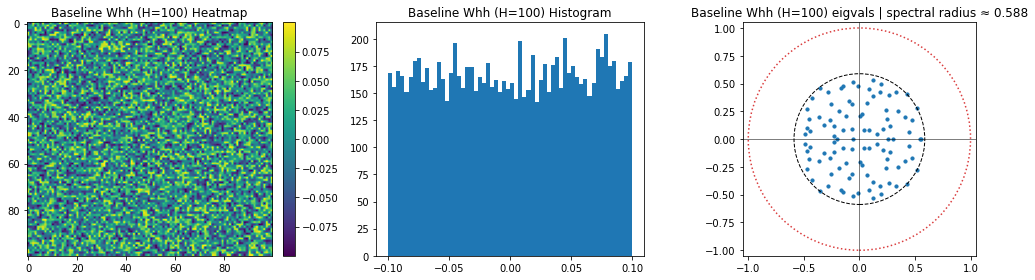

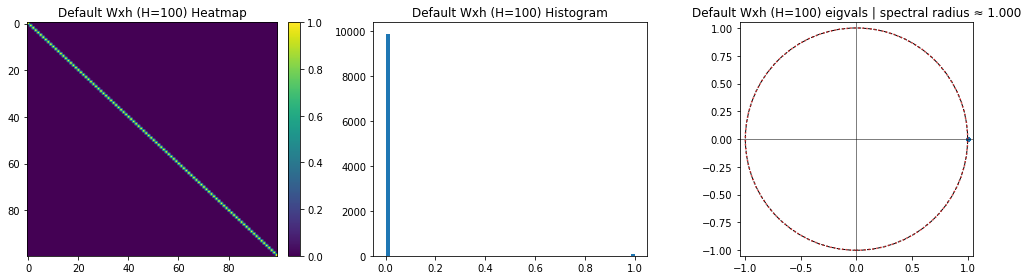

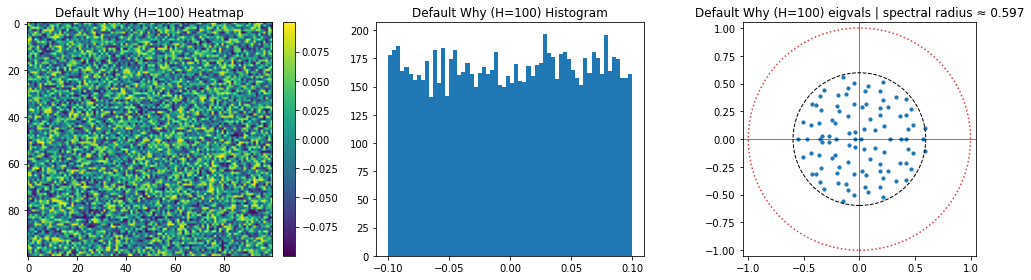

INITIAL SYMMETRY
[Random (raw) — symmetric] var=0.00168453  σ_max=0.7776  ρ=0.7776  asym=0.0000  mean=7.883e-04
[ Random (raw) — skew] var=0.00168272  σ_max=0.7706  ρ=0.7706  asym=2.0000  mean=-1.788e-11


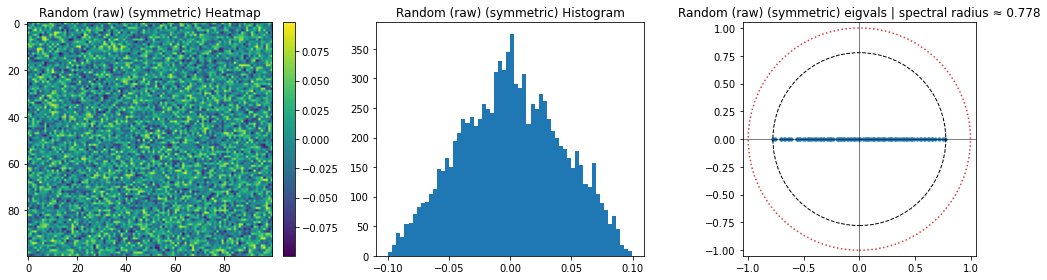

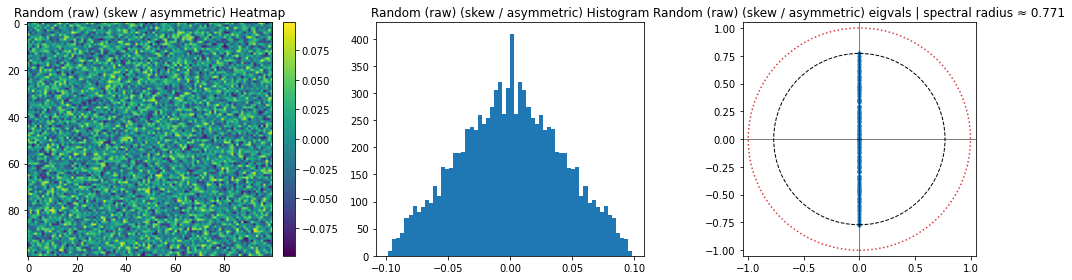

'\nhw.save_matrix(\n    W,\n    save_dir,\n    f"random_baseline",\n    meta={\n        "n": hidden_n,\n    },\n)\n'

In [4]:
# --- Baseline (random) ---
# Baseline random initialization
W, W_xh, W_hy = hw.get_numpy_weights(model)
emp_var = float(W.var())
theo_var = 1.0 / (3.0 * hidden_n)
print(f"empirical var ≈ {emp_var:.6f}, theoretical var ≈ {theo_var:.6f}")
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Baseline Whh (H={hidden_n})")
hw.plot_weight_all(W_xh, title=f"Default Wxh (H={hidden_n})")
hw.plot_weight_all(W_hy, title=f"Default Why (H={hidden_n})")

# 1) Symmetric / skew plots
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Random (raw)")

# 3) Save the baseline matrix
save_dir = "../data/Ns100_SeqN100/hidden-weight-inits"
"""
hw.save_matrix(
    W,
    save_dir,
    f"random_baseline",
    meta={
        "n": hidden_n,
    },
)
"""

## Utility

In [5]:
# =========================
# Example usage
# =========================

save_dir = "../data/Ns100_SeqN100/hidden-weight-inits"
inits = []

### Identity/Shift

INITIAL MATRICES


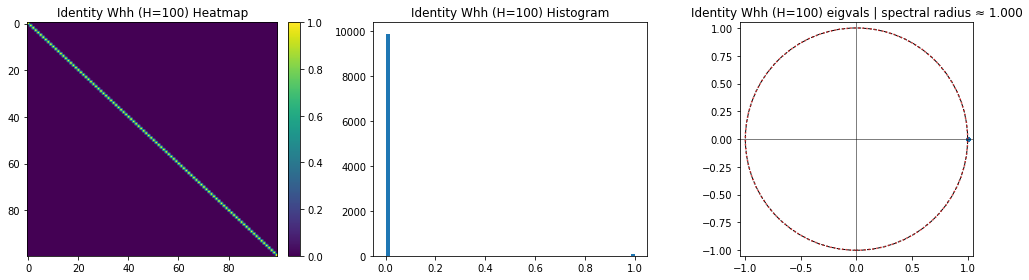

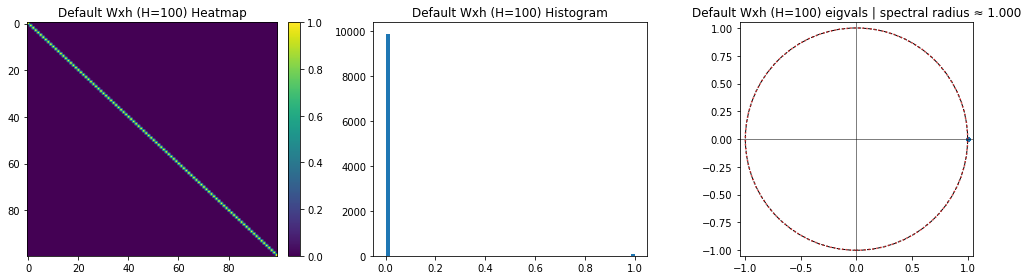

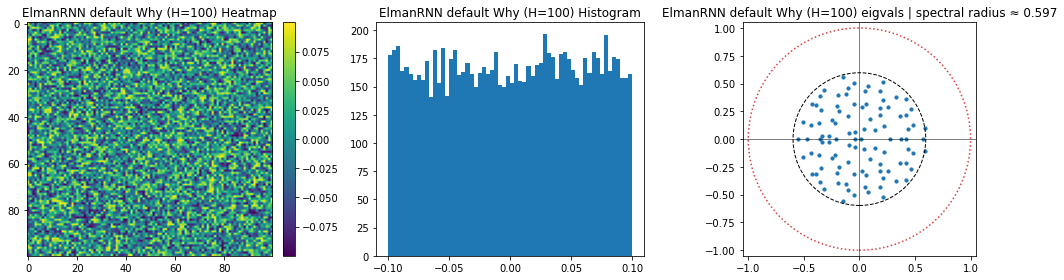

INITIAL SYMMETRY
[Identity (raw) — symmetric] var=0.0099  σ_max=1.0000  ρ=1.0000  asym=0.0000  mean=1.000e-02
[Identity (raw) — skew] var=0  σ_max=0.0000  ρ=0.0000  asym=0.0000  mean=0.000e+00


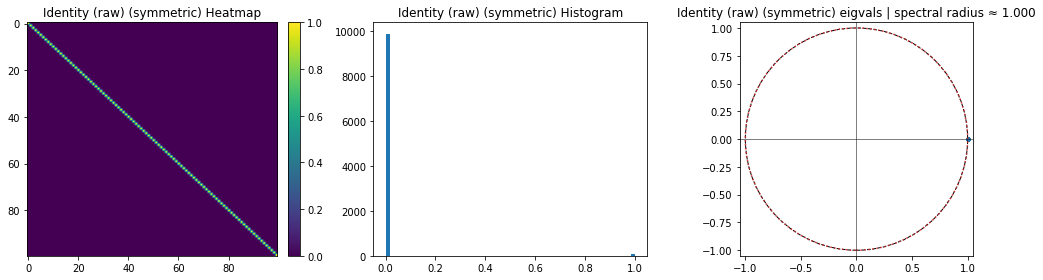

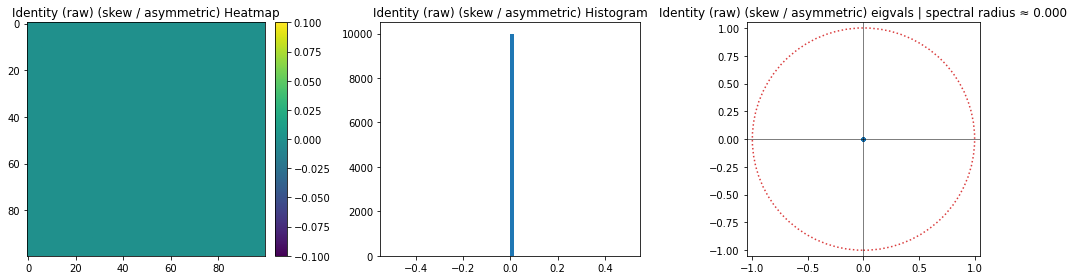

NORMALIZATION COMPARISON


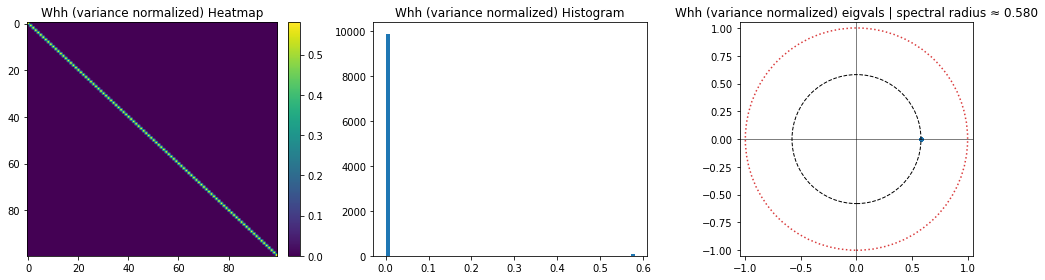

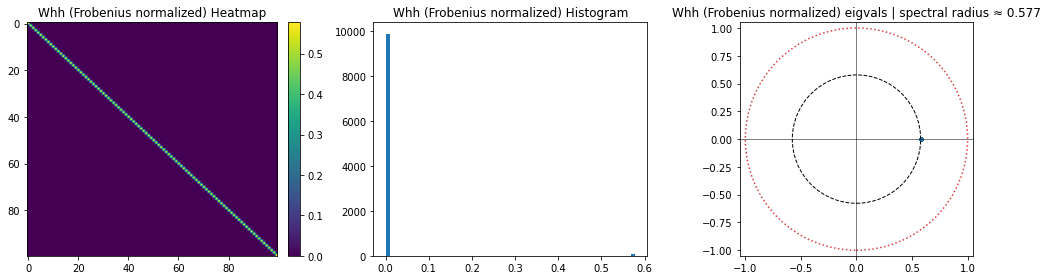

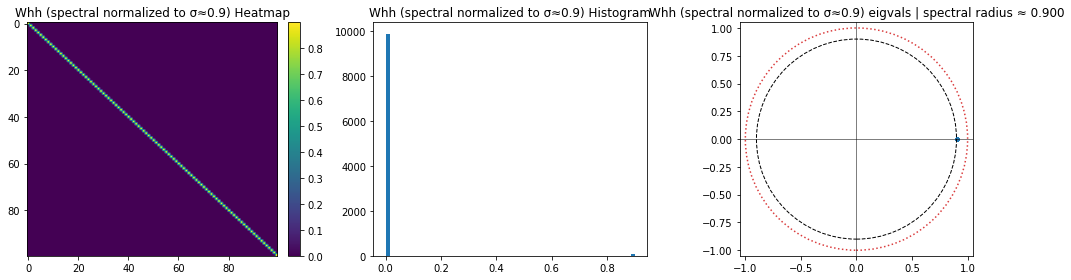

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/identity/raw/identity_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/identity/variance/identity_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/identity/frobenius/identity_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/identity/spectral/identity_n100_spec_gain0p90.npy and .json


In [6]:
# --- identity matrix ---
W = bhw.build_shift(n=hidden_n, value=1.0, offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Identity Whh (H={hidden_n})")
hw.plot_weight_all(W_xh, title=f"Default Wxh (H={hidden_n})")
hw.plot_weight_all(W_hy, title=f"ElmanRNN default Why (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Identity (raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/identity"
hw.save_matrix(W, f"{save_root}/raw", f"identity_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"identity_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"identity_n{hidden_n}_fro", meta={"norm": "fro"}
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"identity_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


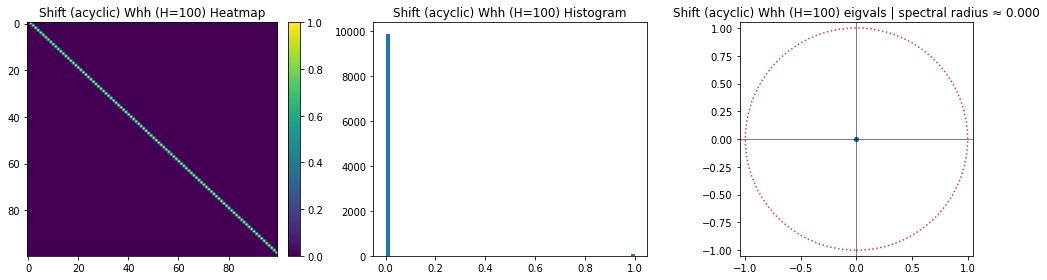

INITIAL SYMMETRY
[Shift (acyclic, raw) — symmetric] var=0.00485199  σ_max=0.9995  ρ=0.9995  asym=0.0000  mean=9.900e-03
[Shift (acyclic, raw) — skew] var=0.00495  σ_max=0.9995  ρ=0.9995  asym=2.0000  mean=0.000e+00


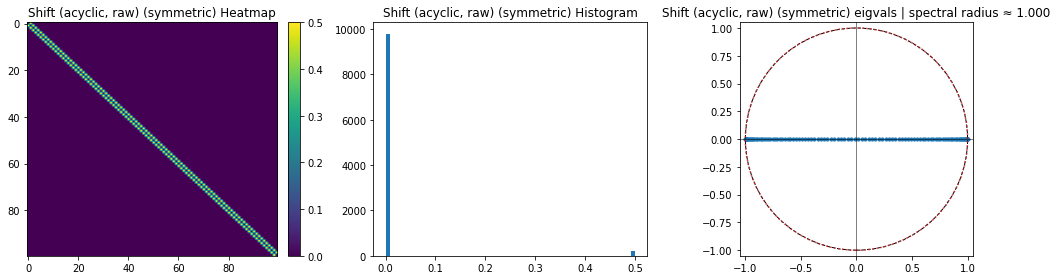

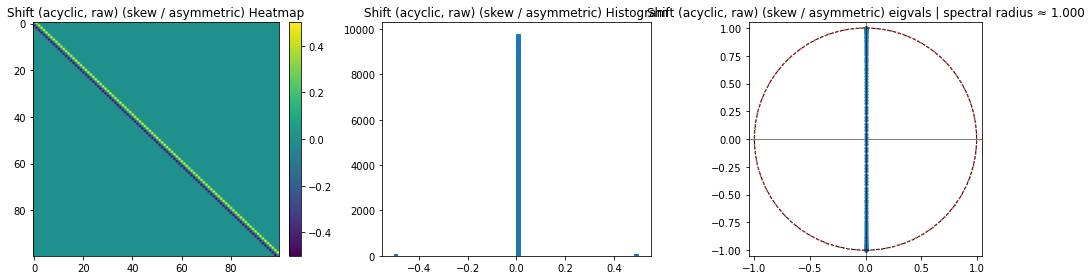

NORMALIZATION COMPARISON


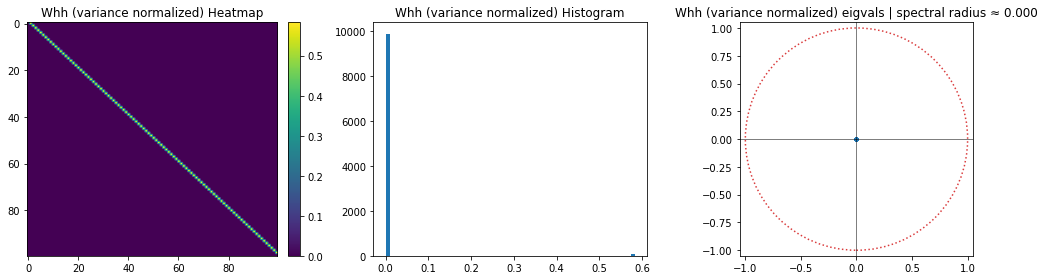

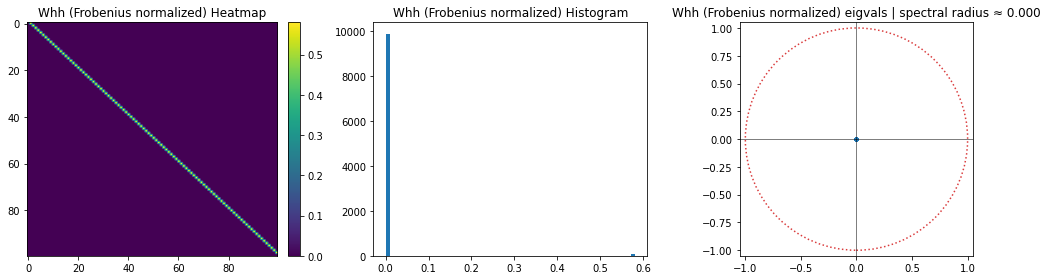

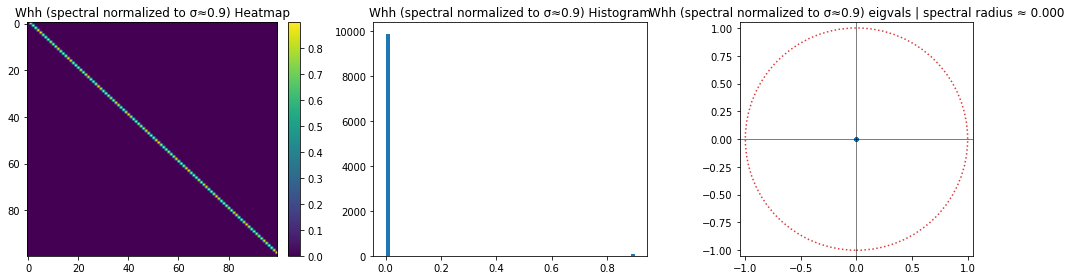

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shift/raw/shift_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shift/variance/shift_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shift/frobenius/shift_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shift/spectral/shift_n100_spec_gain0p90.npy and .json


In [7]:
# --- shift (acyclic) matrix ---
W = bhw.build_shift(n=hidden_n, value=1.0, offset=1, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift (acyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift (acyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shift"
hw.save_matrix(W, f"{save_root}/raw", f"shift_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"shift_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"shift_n{hidden_n}_fro", meta={"norm": "fro"}
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"shift_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


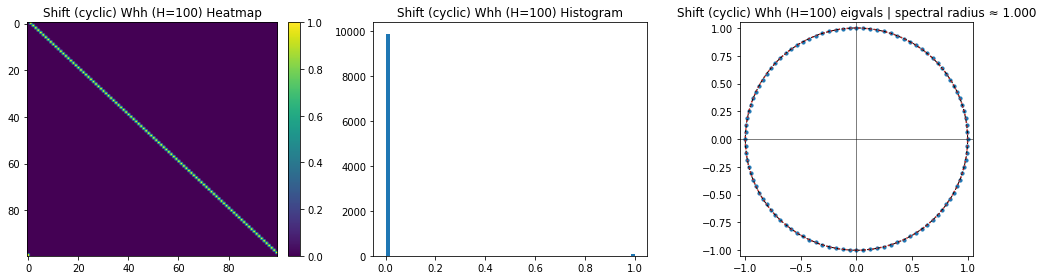

INITIAL SYMMETRY
[Shift (cyclic, raw) — symmetric] var=0.0049  σ_max=1.0000  ρ=1.0000  asym=0.0000  mean=1.000e-02
[Shift (cyclic, raw) — skew] var=0.005  σ_max=1.0000  ρ=1.0000  asym=2.0000  mean=0.000e+00


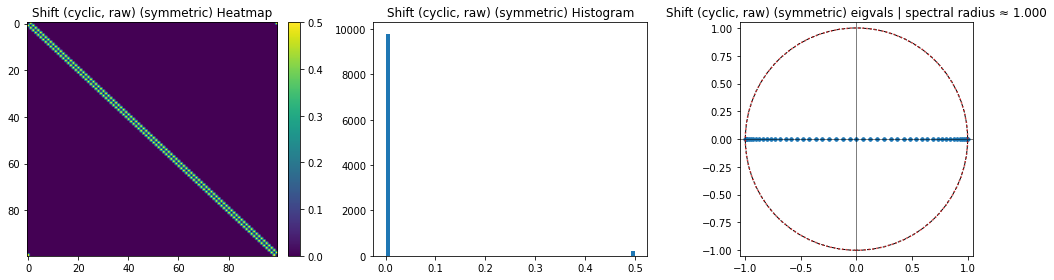

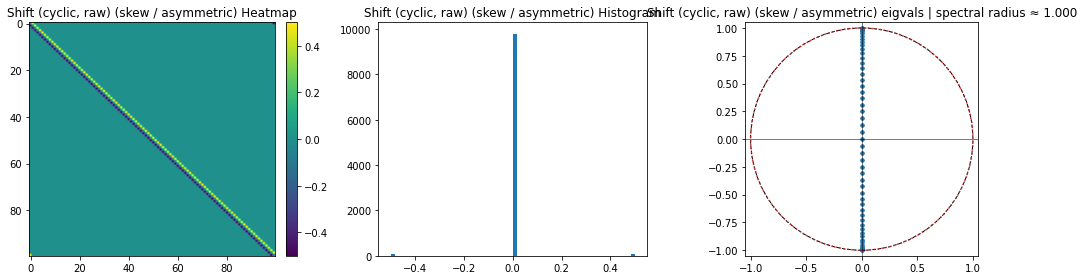

NORMALIZATION COMPARISON


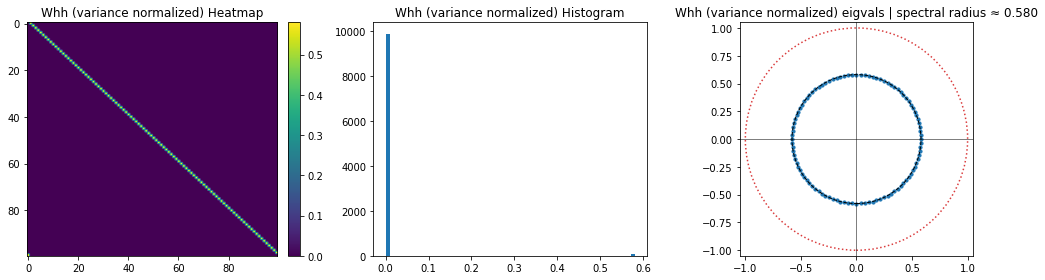

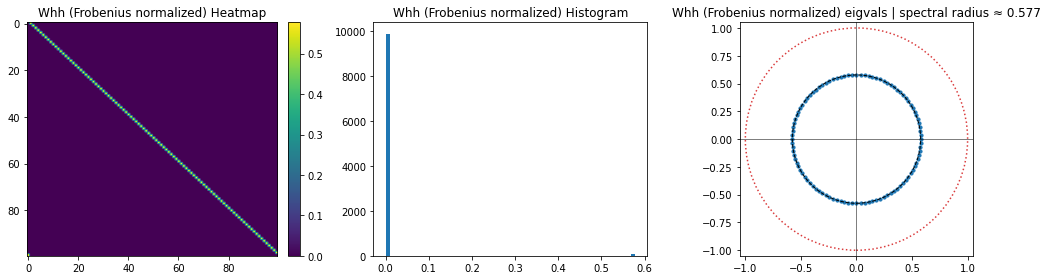

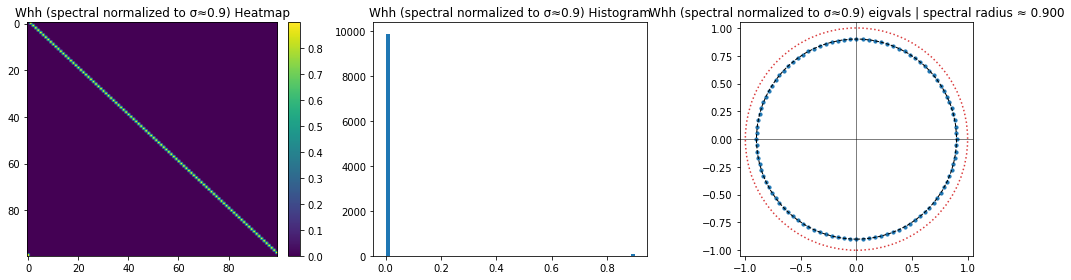

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/cycshift/raw/cycshift_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/cycshift/variance/cycshift_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/cycshift/frobenius/cycshift_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/cycshift/spectral/cycshift_n100_spec_gain0p90.npy and .json


In [8]:
# --- shift (cyclic) matrix ---
W = bhw.build_shift(n=hidden_n, value=1.0, offset=1, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift (cyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift (cyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/cycshift"
hw.save_matrix(W, f"{save_root}/raw", f"cycshift_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"cycshift_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"cycshift_n{hidden_n}_fro", meta={"norm": "fro"}
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"cycshift_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

### Mexican hat

INITIAL MATRICES


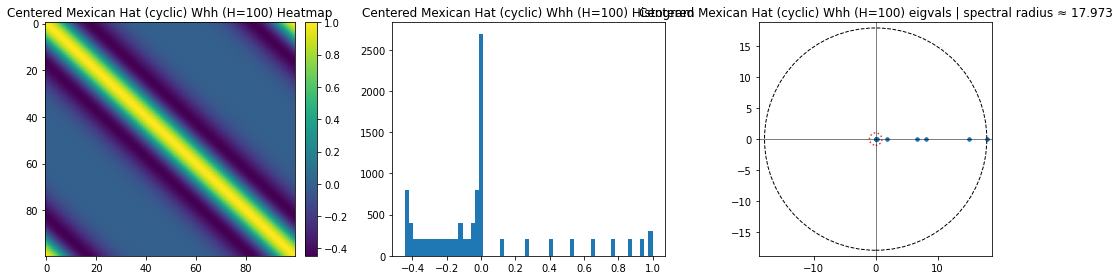

INITIAL SYMMETRY
[Centered Mexican Hat (cyclic, raw) — symmetric] var=0.132934  σ_max=17.9727  ρ=17.9727  asym=0.0000  mean=3.794e-06
[Centered Mexican Hat (cyclic, raw) — skew] var=0  σ_max=0.0000  ρ=0.0000  asym=0.0000  mean=0.000e+00


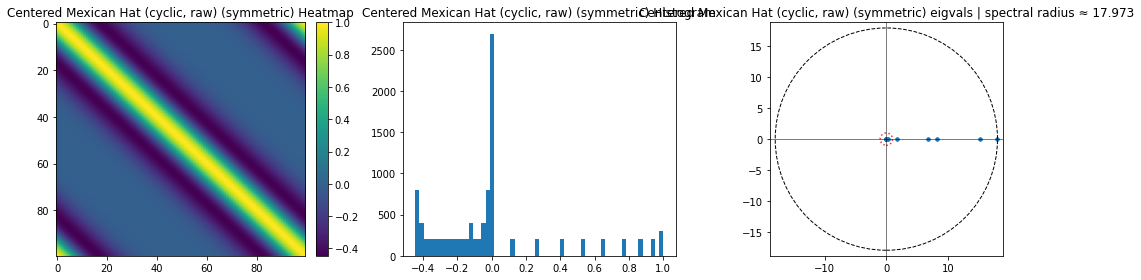

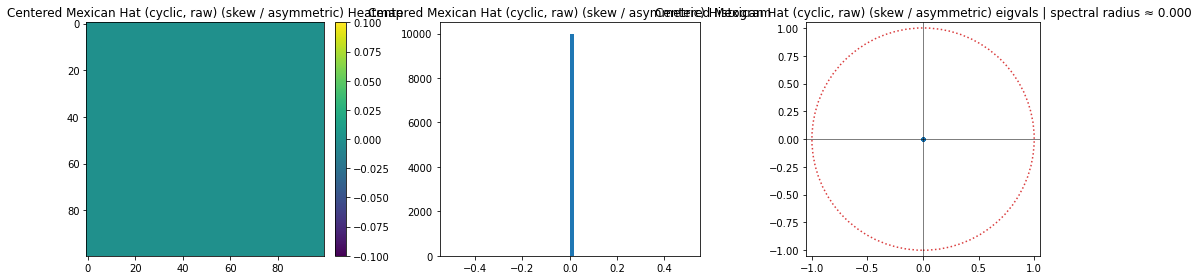

NORMALIZATION COMPARISON


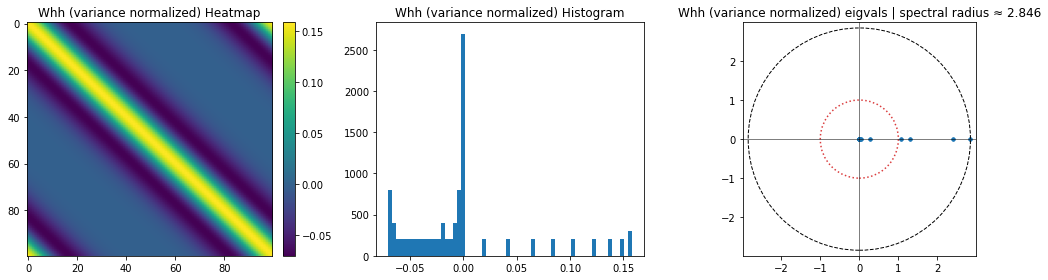

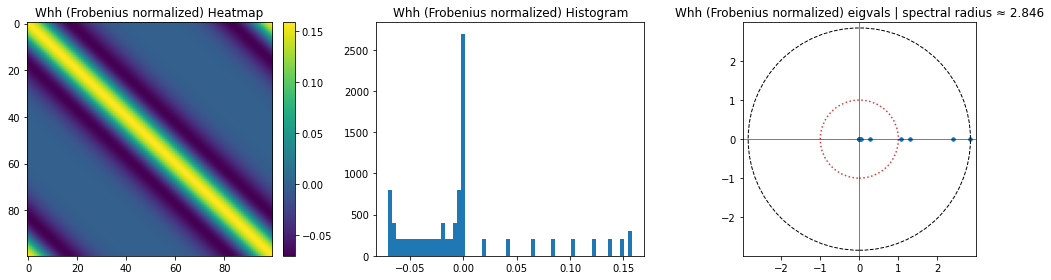

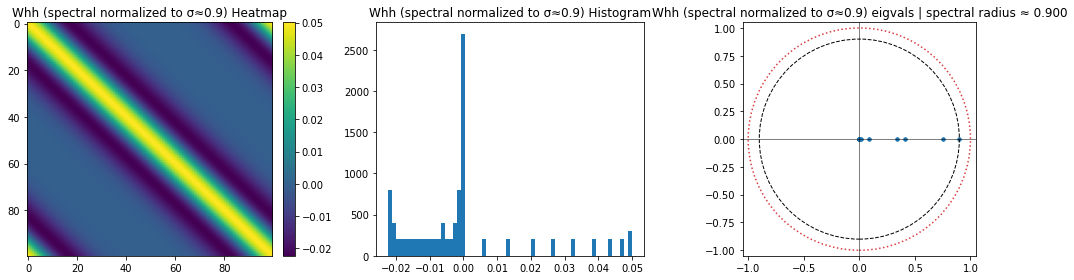

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcycmh/raw/centcycmh_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcycmh/variance/centcycmh_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcycmh/frobenius/centcycmh_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcycmh/spectral/centcycmh_n100_spec_gain0p90.npy and .json


In [9]:
# --- mexican hat (centered, cyclic) matrix ---
W = bhw.build_mexican_hat(n=hidden_n, sigma=None, diag_offset=0, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Mexican Hat (cyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Mexican Hat (cyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centcycmh"
hw.save_matrix(W, f"{save_root}/raw", f"centcycmh_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"centcycmh_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"centcycmh_n{hidden_n}_fro", meta={"norm": "fro"}
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"centcycmh_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


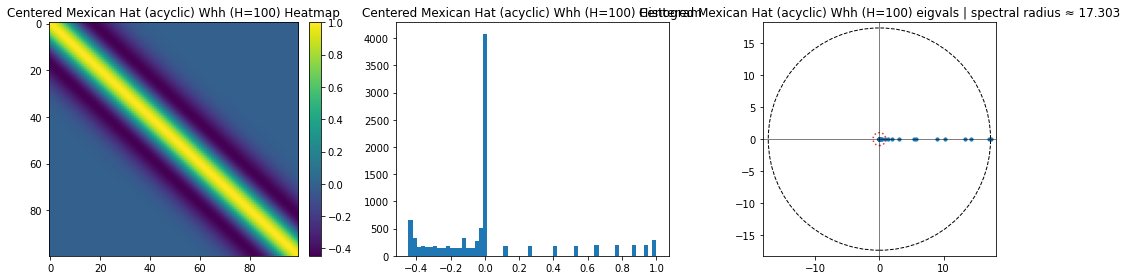

INITIAL SYMMETRY
[Centered Mexican Hat (acyclic, raw) — symmetric] var=0.12255  σ_max=17.3035  ρ=17.3035  asym=0.0000  mean=2.002e-02
[Centered Mexican Hat (acyclic, raw) — skew] var=0  σ_max=0.0000  ρ=0.0000  asym=0.0000  mean=0.000e+00


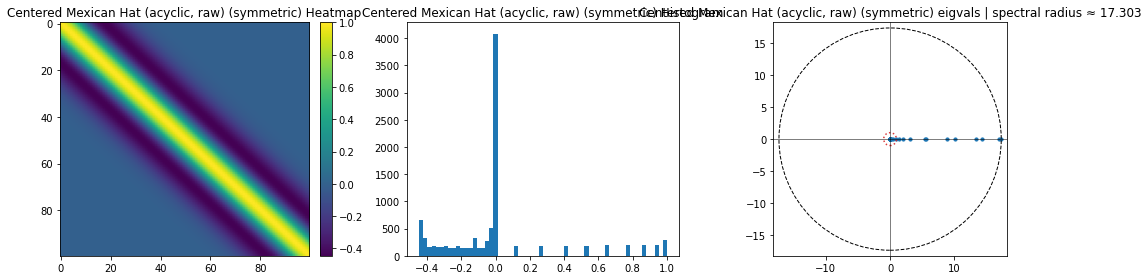

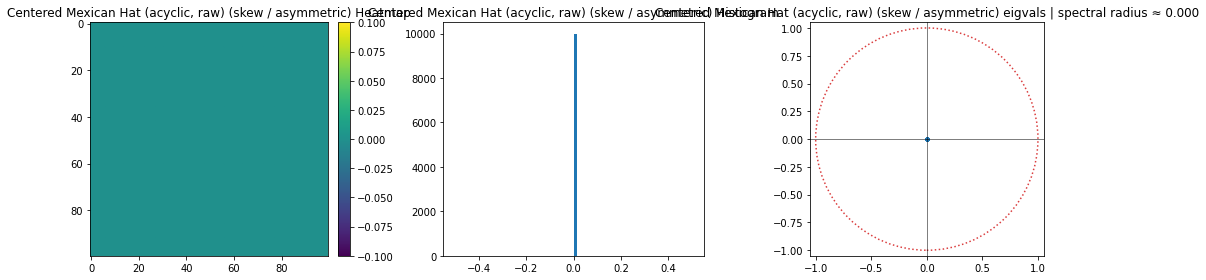

NORMALIZATION COMPARISON


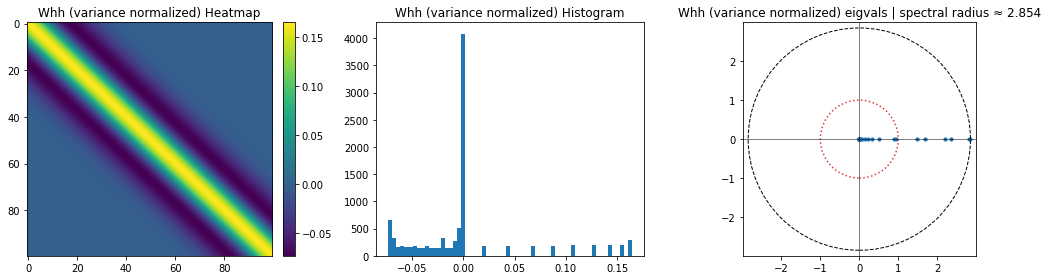

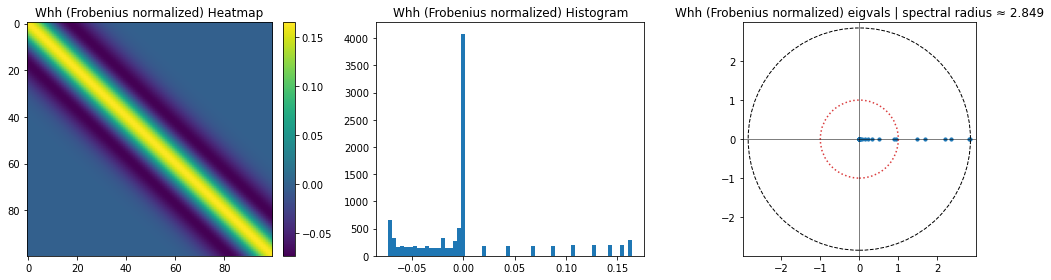

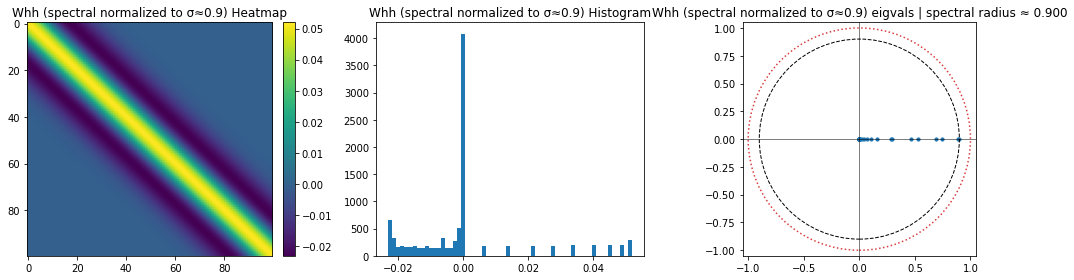

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centmh/raw/centmh_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centmh/variance/centmh_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centmh/frobenius/centmh_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centmh/spectral/centmh_n100_spec_gain0p90.npy and .json


In [10]:
# --- mexican hat (centered, acyclic) matrix ---
W = bhw.build_mexican_hat(n=hidden_n, sigma=None, diag_offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Mexican Hat (acyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Mexican Hat (acyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centmh"
hw.save_matrix(W, f"{save_root}/raw", f"centmh_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"centmh_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"centmh_n{hidden_n}_fro", meta={"norm": "fro"}
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"centmh_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


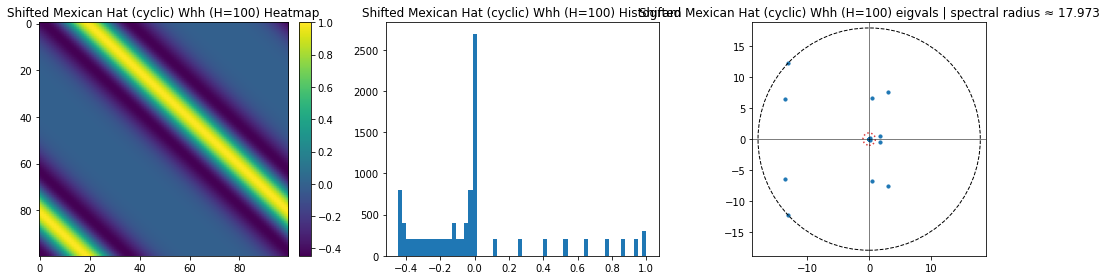

INITIAL SYMMETRY
[Shifted Mexican Hat (cyclic, raw) — symmetric] var=0.0739257  σ_max=13.6368  ρ=13.6368  asym=0.0000  mean=3.794e-06
[Shifted Mexican Hat (cyclic, raw) — skew] var=0.0590083  σ_max=12.3032  ρ=12.3032  asym=2.0000  mean=2.146e-10


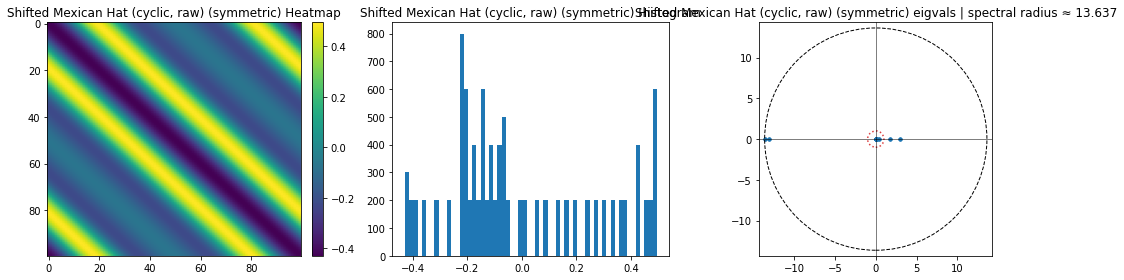

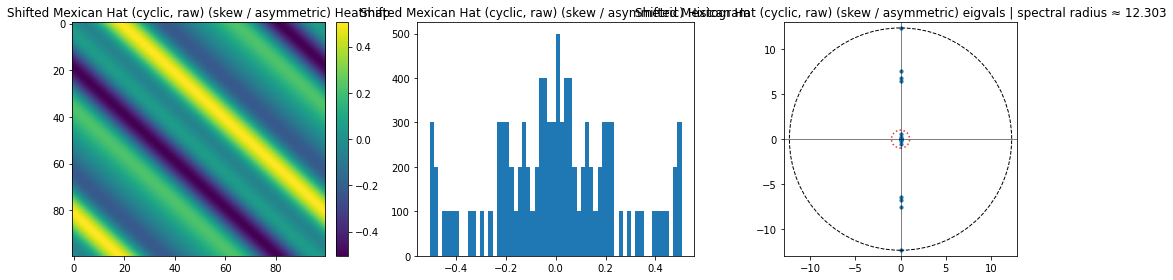

NORMALIZATION COMPARISON


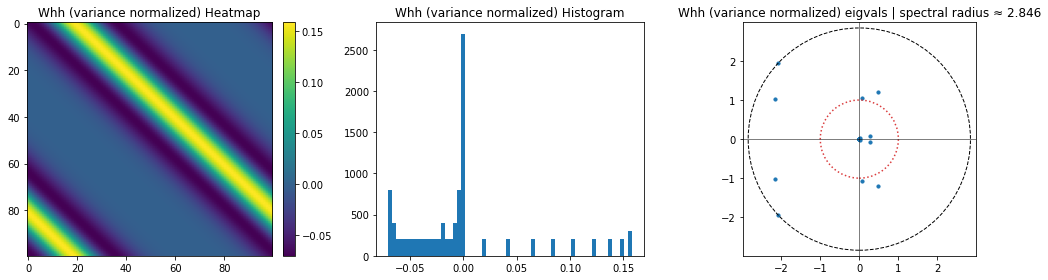

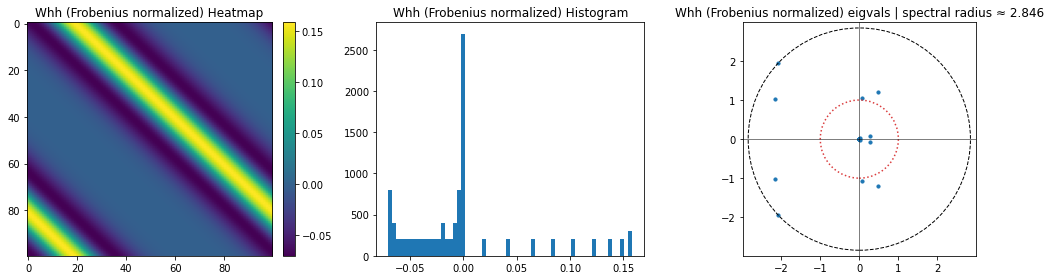

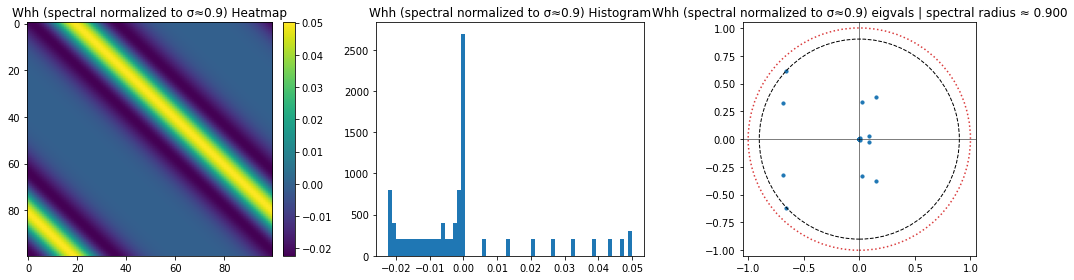

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcycmh/raw/shiftcycmh_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcycmh/variance/shiftcycmh_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcycmh/frobenius/shiftcycmh_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcycmh/spectral/shiftcycmh_n100_spec_gain0p90.npy and .json


In [20]:
# --- mexican hat (centered, cyclic) matrix ---
W = bhw.build_mexican_hat(n=hidden_n, sigma=None, diag_offset=-19, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shifted Mexican Hat (cyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shifted Mexican Hat (cyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shiftcycmh"
hw.save_matrix(W, f"{save_root}/raw", f"shiftcycmh_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"shiftcycmh_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"shiftcycmh_n{hidden_n}_fro", meta={"norm": "fro"}
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"shiftcycmh_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


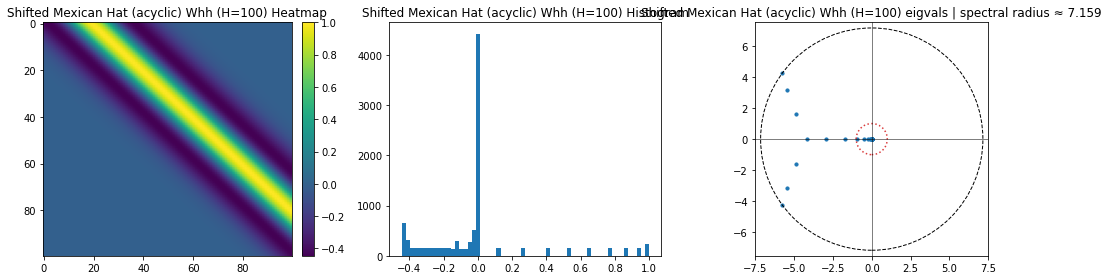

INITIAL SYMMETRY
[Shifted Mexican Hat (acyclic, raw) — symmetric] var=0.0606748  σ_max=14.9364  ρ=14.9364  asym=0.0000  mean=3.282e-03
[Shifted Mexican Hat (acyclic, raw) — skew] var=0.0464174  σ_max=11.5772  ρ=11.5772  asym=2.0000  mean=3.815e-10


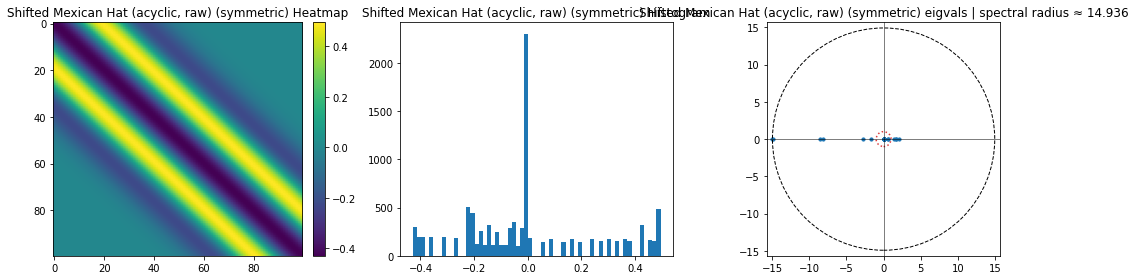

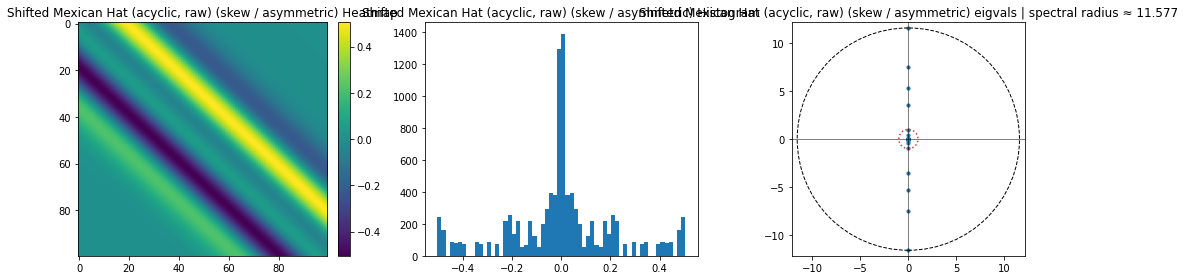

NORMALIZATION COMPARISON


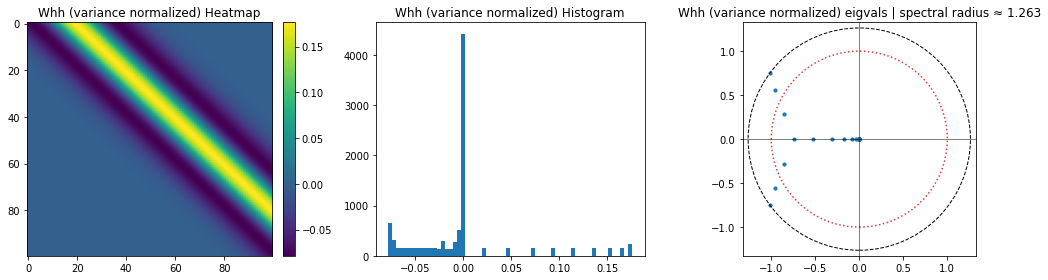

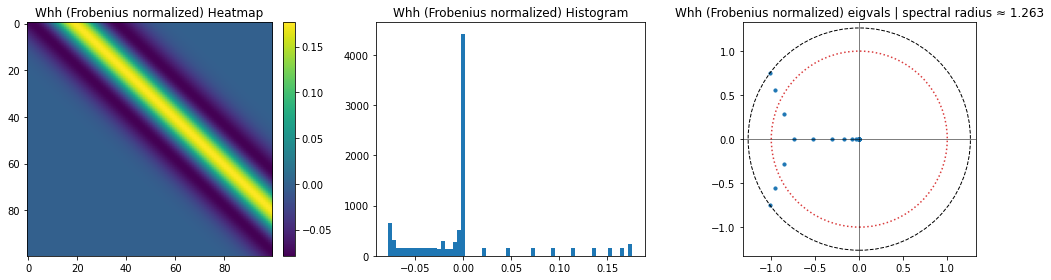

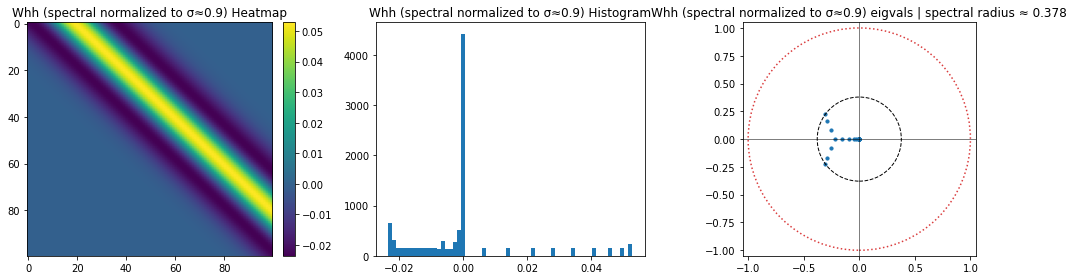

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftmh/raw/shiftmh_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftmh/variance/shiftmh_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftmh/frobenius/shiftmh_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftmh/spectral/shiftcycmh_n100_spec_gain0p90.npy and .json


In [21]:
# --- mexican hat (centered, acyclic) matrix ---
W = bhw.build_mexican_hat(n=hidden_n, sigma=None, diag_offset=-19, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shifted Mexican Hat (acyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shifted Mexican Hat (acyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shiftmh"
hw.save_matrix(W, f"{save_root}/raw", f"shiftmh_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"shiftmh_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"shiftmh_n{hidden_n}_fro", meta={"norm": "fro"}
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"shiftcycmh_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

### Tridiagonal

INITIAL MATRICES


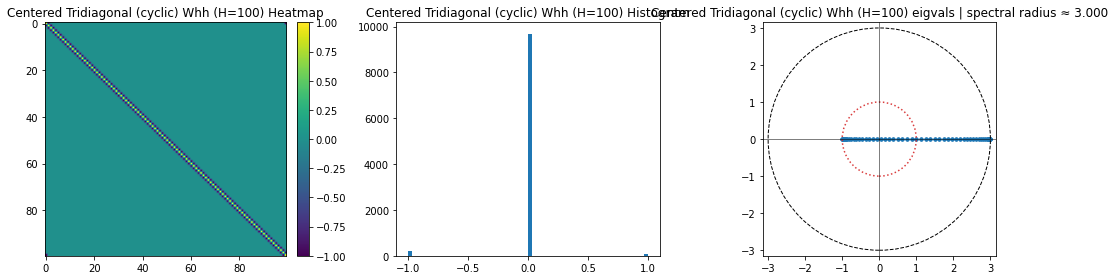

INITIAL SYMMETRY
[Centered Tridiagonal (cyclic, raw) — symmetric] var=0.0299  σ_max=3.0000  ρ=3.0000  asym=0.0000  mean=-1.000e-02
[Centered Tridiagonal (cyclic, raw) — skew] var=0  σ_max=0.0000  ρ=0.0000  asym=0.0000  mean=0.000e+00


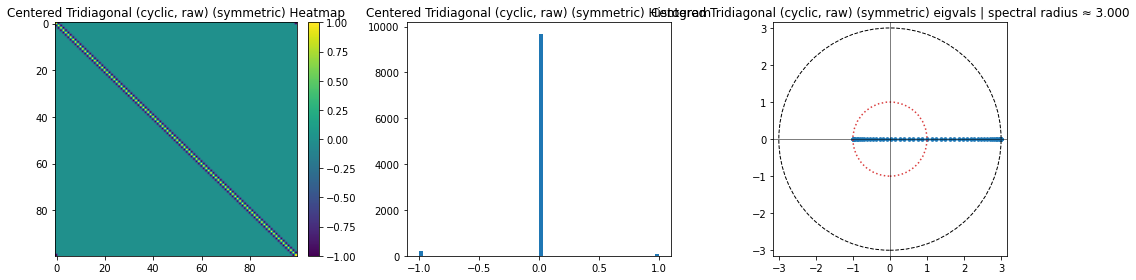

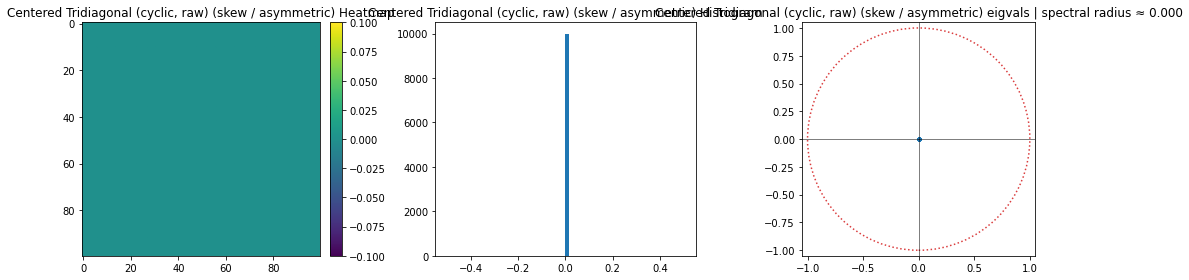

NORMALIZATION COMPARISON


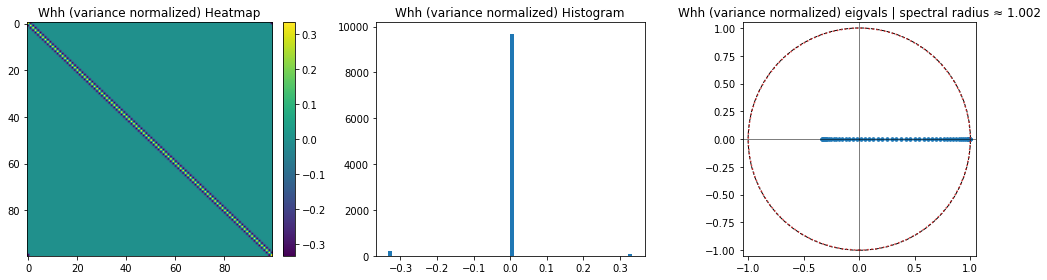

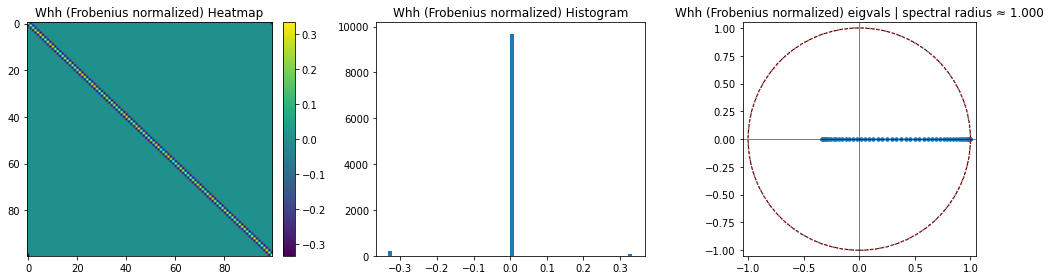

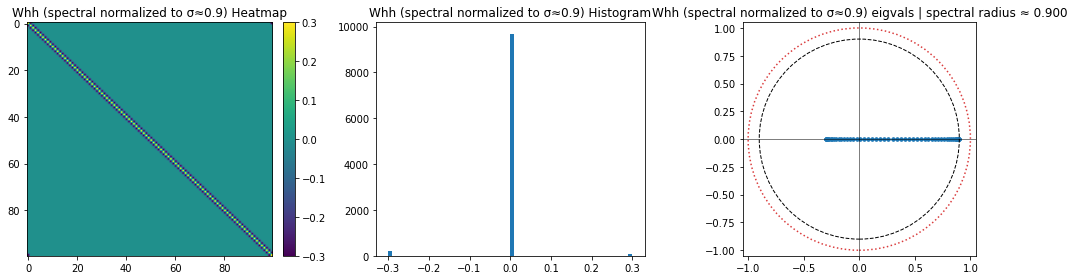

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcyctridiag/raw/centcyctridiag_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcyctridiag/variance/centcyctridiag_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcyctridiag/frobenius/centcyctridiag_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centcyctridiag/spectral/centcyctridiag_n100_spec_gain0p90.npy and .json


In [13]:
# --- tridiagonal (centered, cyclic) matrix ---
W = bhw.build_tridiag(n=hidden_n, diag=1, off=-1, diag_offset=0, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Tridiagonal (cyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Tridiagonal (cyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centcyctridiag"
hw.save_matrix(W, f"{save_root}/raw", f"centcyctridiag_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"centcyctridiag_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"centcyctridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"centcyctridiag_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


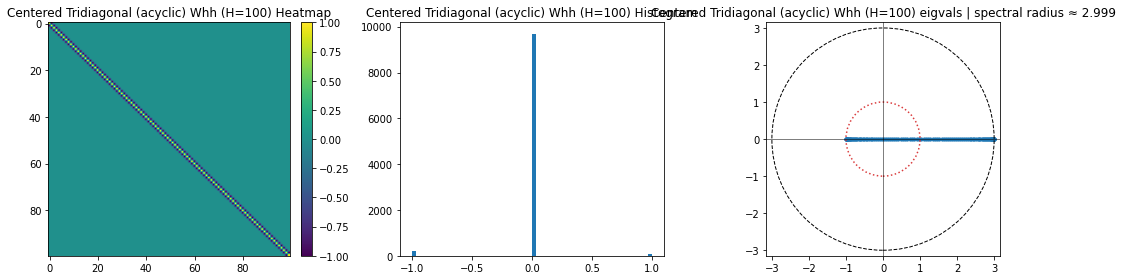

INITIAL SYMMETRY
[Centered Tridiagonal (acyclic, raw) — symmetric] var=0.029704  σ_max=2.9990  ρ=2.9990  asym=0.0000  mean=-9.800e-03
[Centered Tridiagonal (acyclic, raw) — skew] var=0  σ_max=0.0000  ρ=0.0000  asym=0.0000  mean=0.000e+00


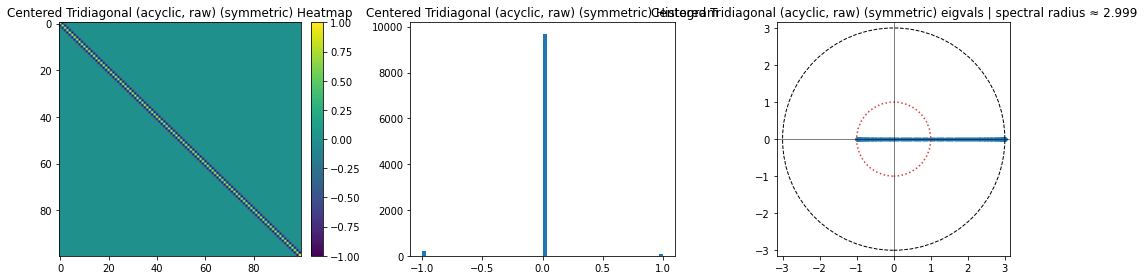

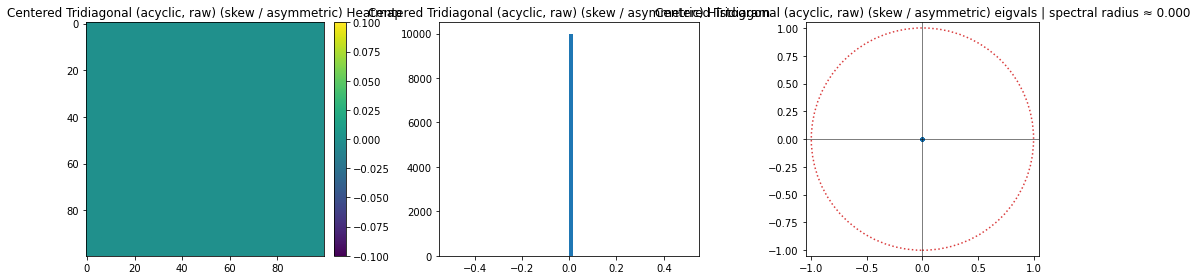

NORMALIZATION COMPARISON


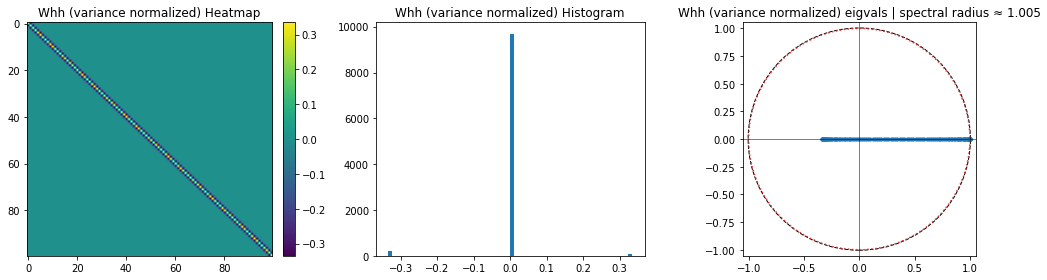

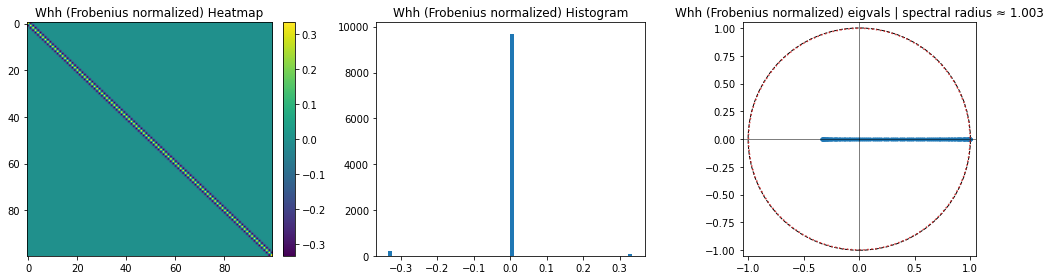

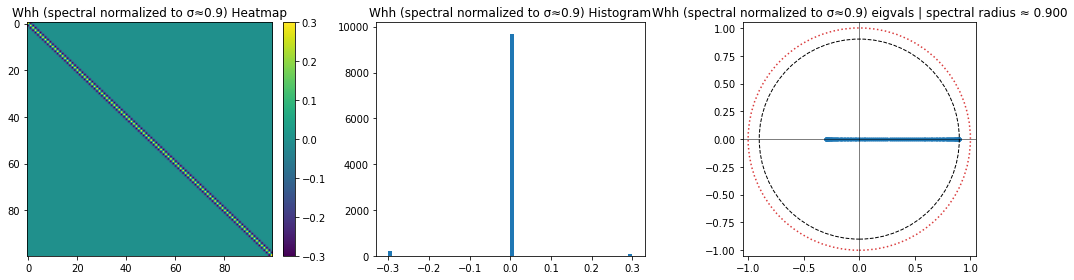

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centtridiag/raw/centtridiag_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centtridiag/variance/centtridiag_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centtridiag/frobenius/centtridiag_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/centtridiag/spectral/centtridiag_n100_spec_gain0p90.npy and .json


In [14]:
# --- tridiagonal (centered, acyclic) matrix ---
W = bhw.build_tridiag(n=hidden_n, diag=1, off=-1, diag_offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Tridiagonal (acyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Tridiagonal (acyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centtridiag"
hw.save_matrix(W, f"{save_root}/raw", f"centtridiag_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"centtridiag_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"centtridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"centtridiag_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


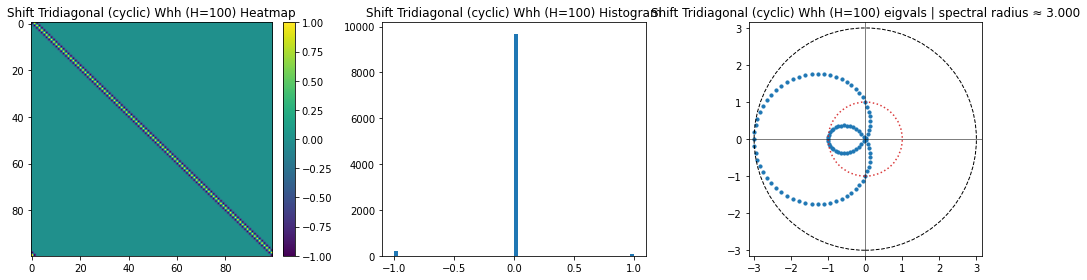

INITIAL SYMMETRY
[Shift Tridiagonal (cyclic, raw) — symmetric] var=0.0199  σ_max=3.0000  ρ=3.0000  asym=0.0000  mean=-1.000e-02
[Shift Tridiagonal (cyclic, raw) — skew] var=0.01  σ_max=1.7601  ρ=1.7601  asym=2.0000  mean=0.000e+00


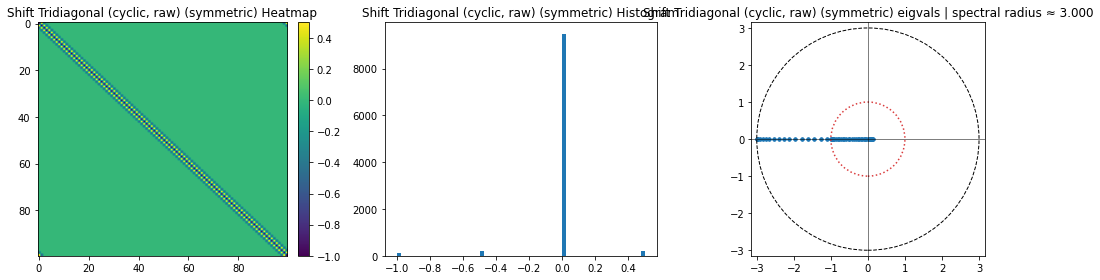

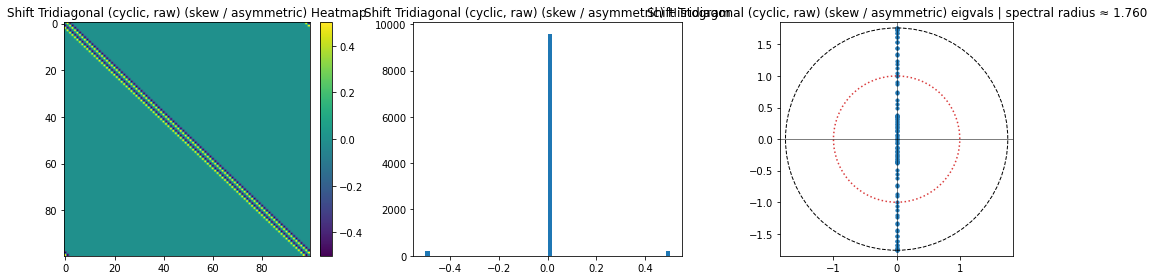

NORMALIZATION COMPARISON


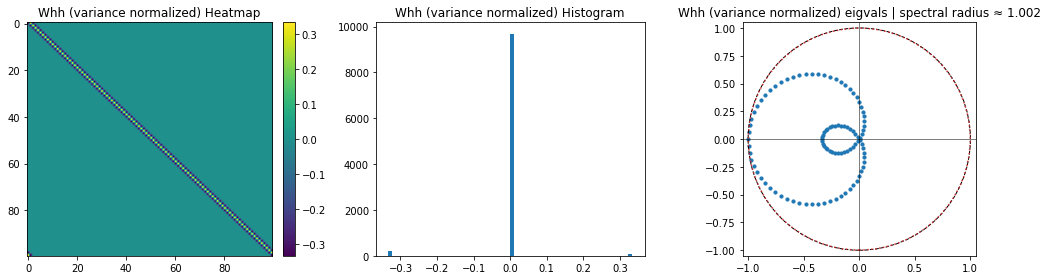

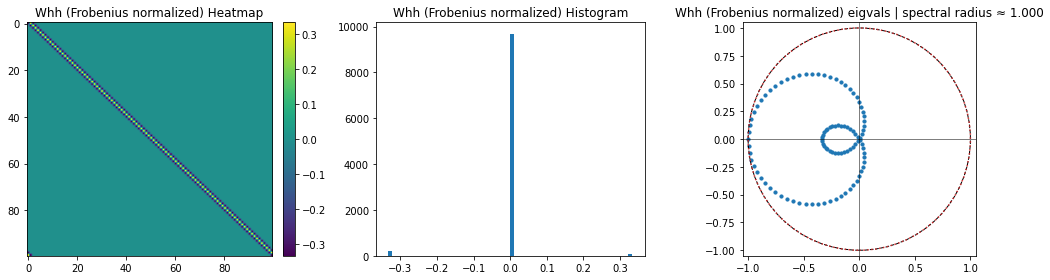

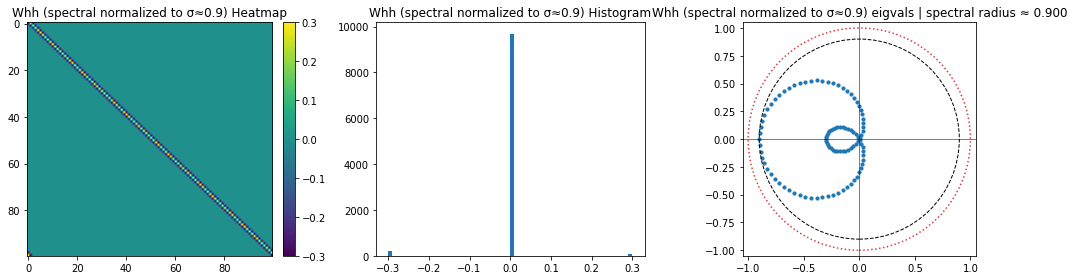

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcyctridiag/raw/shiftcyctridiag_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcyctridiag/variance/shiftcyctridiag_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcyctridiag/frobenius/shiftcyctridiag_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shiftcyctridiag/spectral/shiftcyctridiag_n100_spec_gain0p90.npy and .json


In [15]:
# --- tridiagonal (shift, cyclic) matrix ---
W = bhw.build_tridiag(n=hidden_n, diag=1, off=-1, diag_offset=1, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift Tridiagonal (cyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift Tridiagonal (cyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shiftcyctridiag"
hw.save_matrix(W, f"{save_root}/raw", f"shiftcyctridiag_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"shiftcyctridiag_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shiftcyctridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"shiftcyctridiag_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

INITIAL MATRICES


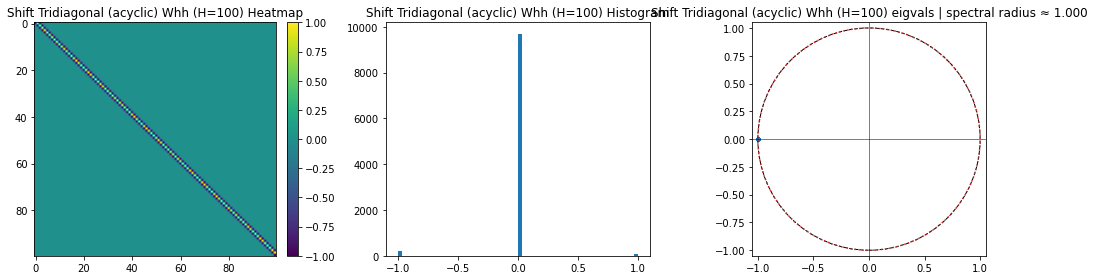

INITIAL SYMMETRY
[Shift Tridiagonal (acyclic, raw) — symmetric] var=0.019752  σ_max=2.9976  ρ=2.9976  asym=0.0000  mean=-9.900e-03
[Shift Tridiagonal (acyclic, raw) — skew] var=0.00985  σ_max=1.7580  ρ=1.7580  asym=2.0000  mean=0.000e+00


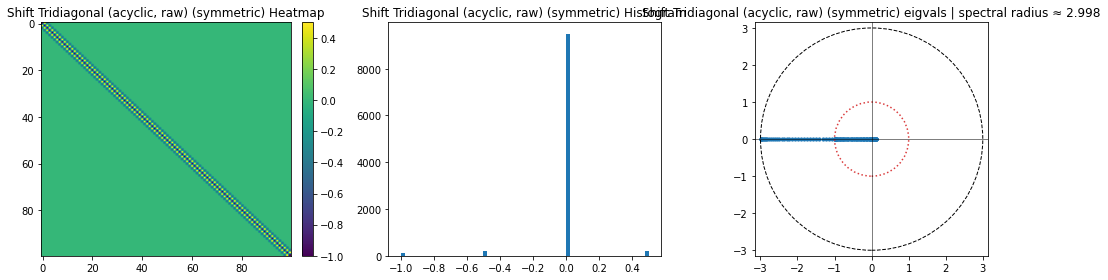

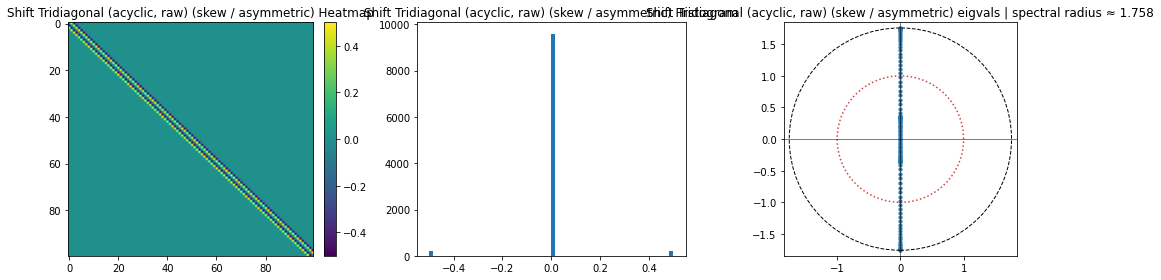

NORMALIZATION COMPARISON


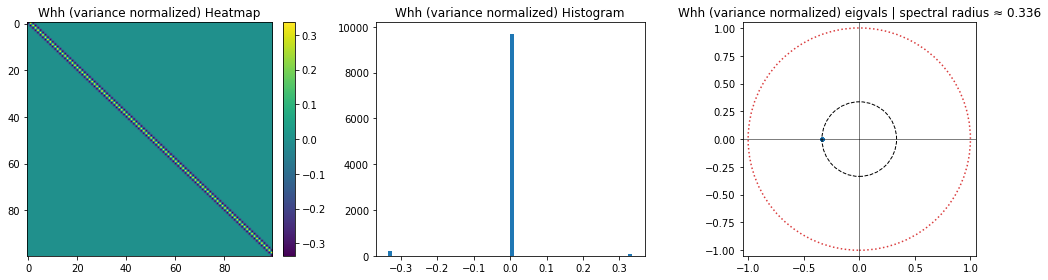

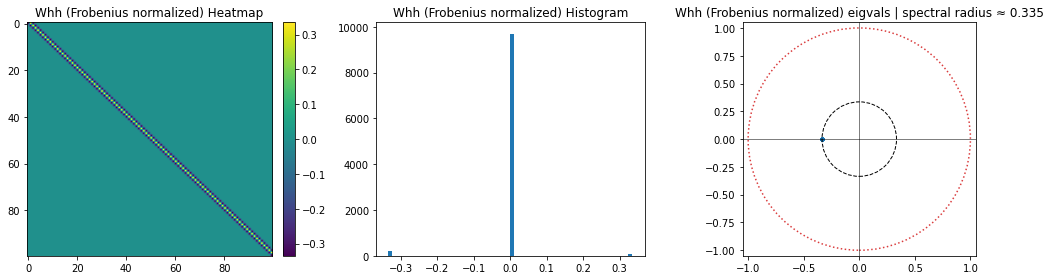

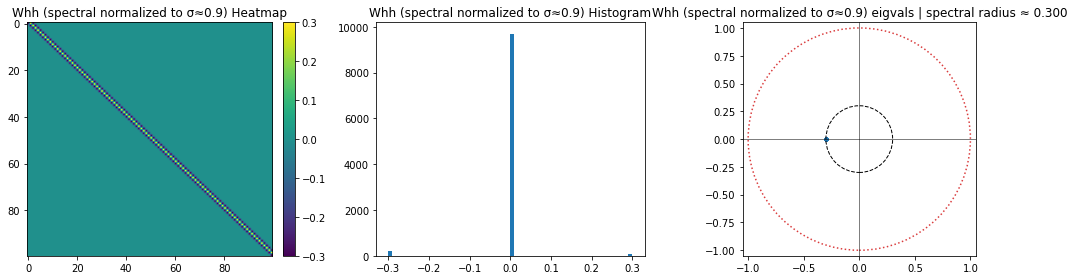

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shifttridiag/raw/shifttridiag_n100_raw.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shifttridiag/variance/shifttridiag_n100_var.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shifttridiag/frobenius/shifttridiag_n100_fro.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/shifttridiag/spectral/shifttridiag_n100_spec_gain0p90.npy and .json


In [16]:
# --- tridiagonal (shift, acyclic) matrix ---
W = bhw.build_tridiag(n=hidden_n, diag=1, off=-1, diag_offset=1, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift Tridiagonal (acyclic) Whh (H={hidden_n})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift Tridiagonal (acyclic, raw)")

# normalization comparisons
theo_var = 1.0 / (3.0 * hidden_n)
target_gain = 0.90
target_fro = (W.size * theo_var) ** 0.5

W_var, _ = hw.normalize_by_variance(W, target_var=theo_var)
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
W_spec, _ = hw.normalize_by_spectral(W, target_sigma=target_gain)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_var, title="Whh (variance normalized)")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")
hw.plot_weight_all(W_spec, title=f"Whh (spectral normalized to σ≈{target_gain})")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shifttridiag"
hw.save_matrix(W, f"{save_root}/raw", f"shifttridiag_n{hidden_n}_raw")
hw.save_matrix(
    W_var,
    f"{save_root}/variance",
    f"shifttridiag_n{hidden_n}_var",
    meta={"norm": "variance"},
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shifttridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W_spec,
    f"{save_root}/spectral",
    f"shifttridiag_n{hidden_n}_spec_{hw.gain_tag(target_gain)}",
    meta={"norm": "spectral", "target_sigma": float(target_gain)},
)

### Orthogonal

In [ ]:
"""
# --- Orthgonal ---
W = bhw.build_orthogonal(
    hidden_n, scale=1.0, seed=0, target_var=None, target_gain=None, verbose=True
)
print("INITIAL MATRICES")
bhw.plot_weight_all(W, title=f"Orthgonal Whh (H={hidden_n})")
bhw.plot_weight_all(W_xh, title=f"Default Wxh (H={hidden_n})")
bhw.plot_weight_all(W_hy, title=f"Default Why (H={hidden_n})")

# 1) Symmetric / skew plots
print("INITIAL SYMMETRY")
bhw.plot_sym_asym(W, base_title="Orthgonal (raw)")

# 3) (Optional) Save the scaled matrix
# save_dir = "../data/Ns100_SeqN100/hidden-weight-inits"
# bhw.save_matrix(W_scaled, save_dir, f"hidden_tridiag_cyc_{bhw.gain_tag(target_gain)}",
#                 meta={"type":"tridiag_cyc", "n": hidden_n, "target_gain": target_gain}
"""